In [1]:
import os, sys

# locate the rl/python directory from the notebook’s folder
root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src  = os.path.join(root, 'dqn.py')        # optional sanity check
pkg  = os.path.join(root, '..')            # up two levels: bot/src/rl

# insert the rl/python folder on the import path
sys.path.insert(0, pkg)

In [2]:
from flax import nnx
import numpy as np
import jax
import jax.numpy as jnp
from jax import profiler
from python.dqn import DqnModel, selectAction, jittedTrain, getOptaxAdamWOptimizer
from copy import deepcopy

In [3]:
batchSize = 128
observationSize = 168
observationStackSize = 64
actionSpaceSize = 35
dropoutRate = 0.1
learningRate = 1e-3

rngSeed = 0
nnxRngs = nnx.Rngs(jax.random.key(rngSeed))

model = DqnModel(
    observationSize=observationSize,
    stackSize=observationStackSize,
    actionSpaceSize=actionSpaceSize,
    dropoutRate=dropoutRate,
    rngs=nnxRngs
)
targetModel = deepcopy(model)

optTx = getOptaxAdamWOptimizer(learningRate)
optimizerState = nnx.Optimizer(model, optTx)

In [4]:
# Input is:
# - pastObservationStack:      (stackSize, observationSize)
# - pastObservationTimestamps: (stackSize, 1)
# - pastActions:               (stackSize, actionSpaceSize)
# - pastMask:                  (stackSize, 1)
# - currentObservation:        (observationSize)
pastObservationStack = jnp.zeros((batchSize, observationStackSize, observationSize))
pastObservationTimestamps = jnp.zeros((batchSize, observationStackSize, 1))
pastActions = jnp.zeros((batchSize, observationStackSize, actionSpaceSize))
pastMask = jnp.zeros((batchSize, observationStackSize, 1))
currentObservation = jnp.zeros((batchSize, observationSize))
actions = jnp.zeros((batchSize, observationStackSize), dtype=np.int32)
isTerminals = jnp.zeros((batchSize,), dtype=np.bool)
rewards = jnp.zeros((batchSize,))
weights = jnp.zeros((batchSize,))


# def jittedTrain(model, optimizerState, targetModel, pastModelInputTuple, selectedActions, isTerminals, rewards, currentModelInputTuple, weights, gamma, rngKey):


      # py::tuple pastModelInputTuple = py::make_tuple(
      #   pastModelInputsNumpy.pastObservationStack,
      #   pastModelInputsNumpy.pastObservationTimestamps,
      #   pastModelInputsNumpy.pastActions,
      #   pastModelInputsNumpy.pastMask,
      #   pastModelInputsNumpy.currentObservation
      # );
toop1 = (pastObservationStack, pastObservationTimestamps, pastActions, pastMask, currentObservation)
toop2 = (pastObservationStack, pastObservationTimestamps, pastActions, pastMask, currentObservation)

profiler.start_trace('logs')
for i in range(10):
  # Train the model
  res = jittedTrain(
    model=model,
    optimizerState=optimizerState,
    targetModel=targetModel,
    pastModelInputTuple=toop1,
    selectedActions=actions,
    isTerminals=isTerminals,
    rewards=rewards,
    currentModelInputTuple=toop2,
    weights=weights,
    gamma=0.99,
    rngKey=jax.random.key(rngSeed)
  )

  jax.block_until_ready(res)
profiler.stop_trace()

2025-05-21 09:30:50.549110: E external/xla/xla/python/profiler/internal/python_hooks.cc:412] Can't import tensorflow.python.profiler.trace
2025-05-21 09:30:55.381979: E external/xla/xla/python/profiler/internal/python_hooks.cc:412] Can't import tensorflow.python.profiler.trace


10 runs of the kernel take 162ms  
16.2ms per run  
61.73 runs/s  
5,333,333 runs/24hr  
With a batch size of 128, that's 682,666,667 samples trained on per 24hrs.  
_(All assuming no overhead for data transfers)_


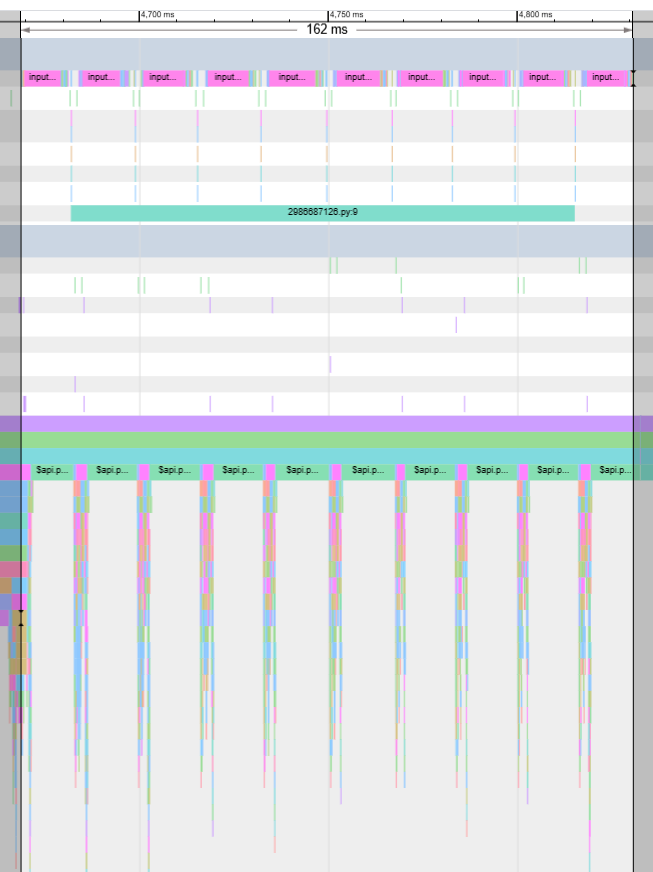